<a href="https://colab.research.google.com/github/martindotpy/apple-quality/blob/main/apple_quality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Preprocesamiento de los datos

In [ ]:
import io
import zipfile
from pathlib import Path
from typing import Final

import pandas as pd
import requests

In [ ]:
dataset_url: Final[str] = (
    "https://www.kaggle.com/api/v1/datasets/download/nelgiriyewithana/apple-quality"
)

In [ ]:
# Descargamos todo el dataset
response = requests.get(
    dataset_url,
    timeout=10,
)

with zipfile.ZipFile(io.BytesIO(response.content)) as zip_file:
    zip_file.extractall("data")

data_path: Final[Path] = Path("data")
files: list[Path] = [*data_path.iterdir()]

# Verificamos que solo haya un archivo
if len(files) > 1:
    raise ValueError("Multiple files downloaded, expected only one")  # noqa: EM101, TRY003

# Guardamos el dataset y eliminamos
raw_dataset_csv_path: Final[Path] = Path("raw_dataset.csv")

if raw_dataset_csv_path.exists():
    raw_dataset_csv_path.unlink()

files[0].rename(raw_dataset_csv_path)
data_path.rmdir()

In [ ]:
dataset_csv_path = Path("dataset.csv")

if dataset_csv_path.exists():
    dataset_csv_path.unlink()

# Eliminamos la última fila con el nombre del creador
with open(raw_dataset_csv_path) as f:
    lines = f.readlines()

# cspell:disable-next-line  # noqa: ERA001
if lines[-1] == ",,,,,,,Created_by_Nidula_Elgiriyewithana,\n":
    with open(dataset_csv_path, "w") as f:
        f.writelines(lines[:-1])

In [ ]:
fruits_df = pd.read_csv(dataset_csv_path, index_col=0)

In [ ]:
# Convertimos la columna 'Quality' a valores booleanos
fruits_df["Quality"] = fruits_df["Quality"].map({"good": 1, "bad": 0})

In [ ]:
fruits_df

,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
A_id,,,,,,,,
0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.329840,-0.491590,1
1,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809,1
2,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636,0
3,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723,1
4,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984,1
...,...,...,...,...,...,...,...,...
3995,0.059386,-1.067408,-3.714549,0.473052,1.697986,2.244055,0.137784,0
3996,-0.293118,1.949253,-0.204020,-0.640196,0.024523,-1.087900,1.854235,1
3997,-2.634515,-2.138247,-2.440461,0.657223,2.199709,4.763859,-1.334611,0


#Entrenamiento del modelo de Machine Learning

In [ ]:
# Importamos la función para dividir los datos en conjuntos de entrenamiento y prueba
from sklearn.model_selection import train_test_split

# Importamos el modelo de regresión logística, que se usará para la clasificación
from sklearn.linear_model import LogisticRegression

# Importamos las métricas que nos ayudarán a evaluar el desempeño del modelo
from sklearn.metrics import accuracy_score, classification_report



In [ ]:
# Eliminamos la columna "Quality" para crear el conjunto de características (entradas)
X = fruits_df.drop(columns=["Quality"])

# Extraemos la columna "Quality" como la variable objetivo (lo que queremos predecir)
y = fruits_df["Quality"]


In [ ]:
# Dividimos los datos en conjunto de entrenamiento y conjunto de prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Inicializamos el modelo de regresión logística, que se utiliza para clasificación binaria
model = LogisticRegression()

# Entrenamos el modelo con los datos de entrenamiento (características X_train y etiquetas y_train)
model.fit(X_train, y_train)


LogisticRegression()

In [ ]:
# Hacemos predicciones sobre el conjunto de prueba usando el modelo entrenado
y_pred = model.predict(X_test)

# Calculamos la precisión del modelo al comparar las predicciones con las etiquetas reales del conjunto de prueba
accuracy = accuracy_score(y_test, y_pred)

# Imprimimos la precisión obtenida, mostrando el valor con dos decimales
print(f"Precisión: {accuracy:.2f}")

# Generamos un reporte detallado de clasificación, que incluye métricas como la precisión, el recall y la puntuación F1
print(classification_report(y_test, y_pred))


Precisión: 0.75
              precision    recall  f1-score   support

           0       0.75      0.76      0.75       401
           1       0.75      0.75      0.75       399

    accuracy                           0.75       800
   macro avg       0.75      0.75      0.75       800
weighted avg       0.75      0.75      0.75       800



In [ ]:
from sklearn.model_selection import cross_val_score

# Evaluar el modelo usando validación cruzada (5 pliegues)
cv_scores = cross_val_score(model, X, y, cv=5)

# Mostrar las puntuaciones de validación cruzada y su media
print(f"Puntuaciones de validación cruzada: {cv_scores}")
print(f"Precisión media en validación cruzada: {cv_scores.mean():.2f}")


Puntuaciones de validación cruzada: [0.77875 0.72375 0.75625 0.74375 0.73625]
Precisión media en validación cruzada: 0.75


#Evaluación del modelo

#Verificación del balanceo del dataset


In [ ]:
#Verificar la distribución de clases en la variable "Quality"
print(fruits_df["Quality"].value_counts(normalize=True))

#El resultado mostrará que el 50.1% de las manzanas son de buena calidad y el 49.9% de mala calidad, indicando un dataset equilibrado y sin sesgo.


Quality
1    0.501
0    0.499
Name: proportion, dtype: float64


#Matriz de confusión

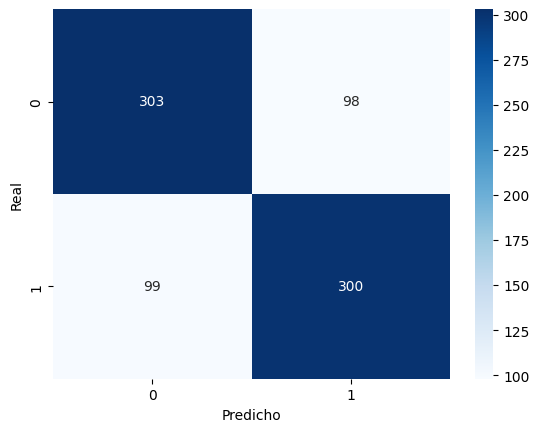

In [ ]:
#Se importan las librerías necesarias para visualizar la matriz de confusión
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#Calculamos la matriz de confusión comparando los valores reales vs predichos
cm = confusion_matrix(y_test, y_pred)

#Creamos un mapa de calor (heatmap) para visualizar la matriz de confusión
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

#Etiquetas de los ejes
plt.xlabel("Predicho")  #Eje X: valores predichos por el modelo
plt.ylabel("Real")  #Eje Y: valores reales del dataset


plt.show()



In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculamos las métricas de evaluación
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Mostramos los resultados
print(f"Precisión: {precision:.2f}")  # Porcentaje de predicciones positivas correctas
print(f"Recall: {recall:.2f}")        # Capacidad del modelo para encontrar positivos reales
print(f"F1-score: {f1:.2f}")          # Promedio armónico entre precisión y recall(mide la capacidad del modelo para identificar correctamente los casos positivos dentro de todos los casos realmente positivos)


Precisión: 0.75
Recall: 0.75
F1-score: 0.75
